Modeling the brusselator

Brusselator:

$$\dot u = D_0\triangle u +a - (b+1)u + u^2v$$
$$ \dot v = D_1\triangle v + bu - u^2v$$
or in other words

$$\dot u = D_0\triangle u +f_u$$
$$ \dot v = D_1\triangle v +f_v$$
This is in 2D. With random initial data. Do I need to worry about initial conditions? No!
I also want to be able to add a new function and a parameter

In [67]:
import numpy as np
from scipy.fft import fftn, ifftn
%matplotlib inline
class Brusselator():
    def __init__(self,N = 100, L = 40*np.pi, a=1.5, b=2.34, D0=2.8, D1=22.4, NUM_STEPS=10**3, dt = 0.05):
        self.N = N
        self.L = L
        self.a = a
        self.b = b
        self.D0 = D0
        self.D1 = D1
        self.NUM_STEPS = NUM_STEPS
        self.dt = dt
        fu = lambda a,b,u,v: a + (u**2)*v - (b+1)*u
        fv = lambda a,b,u,v: b*u-(u**2)*v
        self.fu = fu
        self.fv = fv
    def get_equation_parameters(self):
        return \
        self.a,\
        self.b,\
        self.D0,\
        self.D1
    def get_simulation_parameters(self):
        return \
        self.N,\
        self.L,\
        self.NUM_STEPS,\
        self.dt
    def get_function(self):
        return self.fu, self.fv

In [68]:
# N = 100
# L = 40*np.pi
# a=1.5
# eps = 0.1
# b=2.34
# # b = 1+a**2
# D0=2.8
# D1 = 22.4
# dt = 0.05
# NUM_STEPS =5* 10**3
# fu = lambda a,b,u,v: a + (u**2)*v - (b+1)*u
# fv = lambda a,b,u,v: b*u-(u**2)*v


In [69]:
def create_initial_array(num_of_nodes, ampl = 0.1):
    #return initial concentration of substance. Can be random, should be positive
    return np.random.rand(num_of_nodes,num_of_nodes) * ampl
# for now
def create_wavenumber_array(num_modes, L):
    # create array for wavenumbers in scipy format.
    num_modes = num_modes - num_modes%2 # make num of nodes even. Why?
    wavenum_array = np.zeros(num_modes)
    wavenum = 2*np.pi/L
    p1 = np.array([(wavenum * i) for i in range(int(num_modes/2))])
    p2 = np.array([wavenum * (-num_modes+n) for n in range(int(num_modes/2), num_modes)])
    wavenum_array = np.concatenate((p1,p2))
    return wavenum_array
def create_time_operator(wavenums, diffusion_coeff, timestep):
    ## create a time evolution operator
    num_nodes = wavenums.size
    operator = np.empty((num_nodes,num_nodes))
    wavenums = wavenums**2
    wavenums_sq = wavenums[:, np.newaxis]+wavenums
    operator = np.exp(-wavenums_sq*timestep*diffusion_coeff)
    
    return operator

In [70]:
def perform_simulation(brusselator_class = Brusselator(), save_full = False):
    a, b, D0, D1 = brusselator_class.get_equation_parameters()
    N, L, NUM_STEPS, dt = brusselator_class.get_simulation_parameters()
    fu,fv = brusselator_class.get_function()
    savetimes = [0, NUM_STEPS//2, NUM_STEPS-2]

    # initialize data
    initial_data_u = create_initial_array(N)
    initial_data_v = create_initial_array(N)
    wavenums = create_wavenumber_array(N, L)

    ## initialize operators
    operator_u = create_time_operator(wavenums, D0, dt)
    operator_v = create_time_operator(wavenums, D1, dt)
    
    ##initialize data
    u = initial_data_u
    v = initial_data_v

    u_saved = []
    v_saved = []

    ## initialize saved data
    # shape = savetimes.shape+initial_data_u.shape    
    if save_full == True:
        time = np.empty(NUM_STEPS)
        time[0] = 0
        shape = time.shape+initial_data_u.shape
        conc_u = np.empty(shape)
        conc_v = np.empty(shape)

    ## begin calculations
    ## I could make it prettier. Create save_resutls function
    for i in range(NUM_STEPS-1):
        if save_full == True:
            conc_u[i] = u
            conc_v[i] = v

        if save_full == False:
            if i in savetimes:
                u_saved.append(u)
                v_saved.append(v)

        ## checking progress
        progress = float(i/NUM_STEPS)
        print(f"Progress: {progress}", end='\r', flush=True)
        ## apply euler scheme
        nonlin_u = u + fu(a,b,u,v)*dt
        nonlin_v = v + fv(a,b,u,v)*dt
        ## use Fourier transform
        ## NOTES: I could combine u and v into complex array.
        fft_u = fftn(nonlin_u)
        fft_v = fftn(nonlin_v)

        ## perform timestep in fourier domain
        fft_u = fft_u * operator_u
        fft_v = fft_v * operator_v

        ## go back
        u = ifftn(fft_u).real
        v = ifftn(fft_v).real


    if save_full == True:
        return time, conc_u, conc_v
    else:
        return u_saved, v_saved


To check:

oscillatory solution $b = 1+a^2$, needs animation

amlitude evolution

check for nghood of critical value

check for wavenumber 

Tonks gas


spectral methods for pdes


chebyshev and fourier spectral method boyd

add estimated time

In [71]:
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

def simulate_and_plot(brusselator_class ,name = "default.png", save = False):
    a, b, D0, D1 = brusselator_class.get_equation_parameters()
    N, L, NUM_STEPS, dt = brusselator_class.get_simulation_parameters()

    data_u, data_v = perform_simulation(brusselator_class)
    xs = np.arange(0.0,L,L/N)
    ys = np.arange(0.0,L,L/N)
    # print(f"time = {dt*NUM_STEPS}")
    X,Y = np.meshgrid(xs,ys)

    from matplotlib import animation, rc
    from IPython.display import HTML

    fig = plt.figure(figsize=(27,15))
    fig.suptitle(f"Simulation for a={a},b={b},NUM_STEPS={NUM_STEPS},N={N}, D0={D0}, D1={D1}, dt = {dt}, L={L}", fontsize =12)  
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)

    ax1.pcolormesh(X, Y, data_u[0], shading='auto')
    ax2.pcolormesh(X, Y, data_u[1], shading='auto')
    ax3.pcolormesh(X, Y, data_u[2], shading='auto')
    ax3.set_title(f"time={dt*NUM_STEPS}")
    ## another plot
    # def show_patterns(U, ax=None):
    #     ax.imshow(U, cmap=plt.cm.copper,
    #             interpolation='bilinear',
    #             extent=[-1, 1, -1, 1])
    #     ax.set_axis_off()
    # U=data_u[2]
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # show_patterns(U, ax=ax)
    if save == True:
        fig.savefig(name, bbox_inches='tight')
    plt.show()

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import rc
def run_animation(brusselator_class):
    time, u, v = perform_simulation(brusselator_class, save_full=True)
    ## Plot u(x,y) as animation (2D)
    N, L, NUM_STEPS, dt = brusselator_class.get_simulation_parameters()

    data_red = np.concatenate([u[::40, :, :]])  ## less data to show
    ## ::400 means take every 400th step. The rest means take everything
    xs = np.arange(0.0, L, L / N)
    ys = np.arange(0.0, L, L / N)

    X, Y = np.meshgrid(xs, ys)

    fig = plt.figure()
    ax = plt.subplot(111)
    fond = ax.pcolormesh(X, Y, data_red[0], shading='auto')  # Initialize with the first frame

    def animate(i):
        fond.set_array(data_red[i].ravel())  # Update the data of pcolormesh
        return fond,

    anim = animation.FuncAnimation(fig, animate, frames=range(data_red.shape[0]), interval=100, repeat_delay=1000)
    rc('animation', html='jshtml')

    plt.close(anim._fig)
    return HTML(anim.to_jshtml())

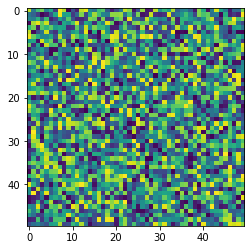

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def display_animation(data, interval=200):
    """
    Display a 2D HTML animation from a 3D array in a Jupyter Notebook.
    
    Parameters:
        data (np.ndarray): 3D array of shape (time, x, y).
        interval (int): Interval between frames in milliseconds.
    """
    # Ensure the input data is a 3D numpy array
    if not isinstance(data, np.ndarray) or data.ndim != 3:
        raise ValueError("Input data must be a 3D numpy array")

    # Get the number of frames from the first dimension of the array
    num_frames, x_dim, y_dim = data.shape
    
    # Create a figure and an axis
    fig, ax = plt.subplots()
    
    # Determine the min and max values for the color scale
    vmin = np.min(data)
    vmax = np.max(data)
    
    # Initialize the plot with the first frame and set the color limits
    im = ax.imshow(data[0, :, :], cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)

    # Function to update the plot for each frame
    def update(frame):
        im.set_array(data[frame, :, :])
        return [im]
    
    # Create the animation
    anim = FuncAnimation(fig, update, frames=num_frames, interval=interval, blit=True)
    
    # Display the animation in the notebook
    return HTML(anim.to_jshtml())

# Example usage
# Create a 3D array with random data for demonstration
time_steps = 100
x_dim, y_dim = 50, 50
data = np.random.random((time_steps, x_dim, y_dim))

# Display the HTML animation
display_animation(data, interval=100)


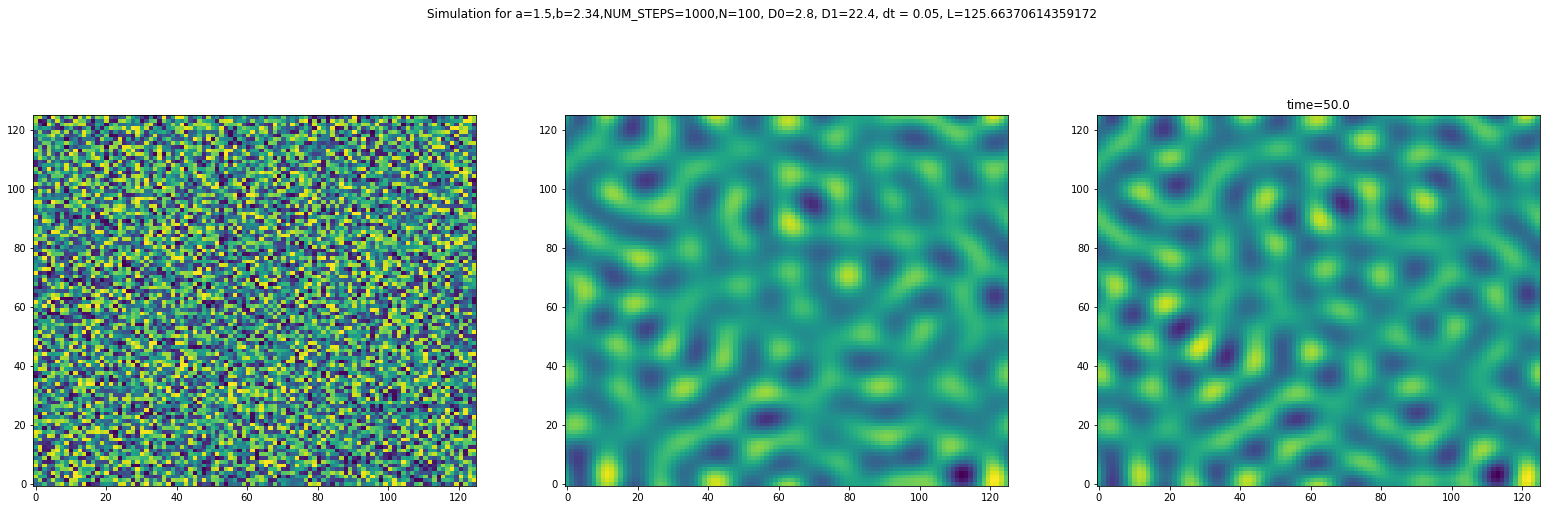

In [81]:
simulate_and_plot(Brusselator())

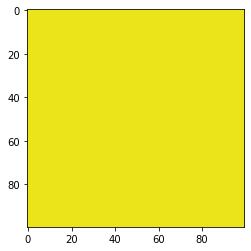

In [80]:
def_brusselator = Brusselator(dt= 0.05)
# simulate_and_plot(def_brusselator)
t, data, v = perform_simulation(def_brusselator, save_full=True)
data = data[::40,:,:]
display_animation(data)

I got nice results for

N = 256

L = 20\pi

a=1.5

b=2.34

D0=2.8

D1 = 22.4

dt = 0.05

NUM_STEPS = 10**3

FOR 

N = 1200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3
Also interesting at least at time NUM_STEPS/2


Also interesting
N = 200
a=1.5
b=2.34
D0=2.8
D1 = 22.4
dt = 0.05
NUM_STEPS = 10**3

What do I want from the simulation?
I want to be able to change the parameters rather easily. Or display a bunch of plots 
What parameters do I have?